In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd
import os
from tqdm import tqdm # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flickr8k/captions.txt
/kaggle/input/flickr8k/Images/3226254560_2f8ac147ea.jpg
/kaggle/input/flickr8k/Images/214543992_ce6c0d9f9b.jpg
/kaggle/input/flickr8k/Images/2366643786_9c9a830db8.jpg
/kaggle/input/flickr8k/Images/3368819708_0bfa0808f8.jpg
/kaggle/input/flickr8k/Images/2190227737_6e0bde2623.jpg
/kaggle/input/flickr8k/Images/2752809449_632cd991b3.jpg
/kaggle/input/flickr8k/Images/3097776588_312932e438.jpg
/kaggle/input/flickr8k/Images/1206506157_c7956accd5.jpg
/kaggle/input/flickr8k/Images/1319634306_816f21677f.jpg
/kaggle/input/flickr8k/Images/2465218087_fca77998c6.jpg
/kaggle/input/flickr8k/Images/3351493005_6e5030f596.jpg
/kaggle/input/flickr8k/Images/2949337912_beba55698b.jpg
/kaggle/input/flickr8k/Images/534886684_a6c9f40fa1.jpg
/kaggle/input/flickr8k/Images/3543600125_223747ef4c.jpg
/kaggle/input/flickr8k/Images/2174206711_11cb712a8d.jpg
/kaggle/input/flickr8k/Images/280706862_14c30d734a.jpg
/kaggle/input/flickr8k/Images/2100735137_05c6079537.jpg
/kaggle/input/f

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.layers import (Embedding, LSTM, add, Concatenate, 
                                     Reshape, concatenate, Bidirectional, 
                                     Input, Dense)
from tensorflow.keras.models import Model, Sequential

2026-01-15 12:03:58.433796: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768478638.772961      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768478638.868938      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768478639.746639      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768478639.746690      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768478639.746692      55 computation_placer.cc:177] computation placer alr

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [4]:
import warnings
import matplotlib as plt
import seaborn as sns
from textwrap import wrap

In [5]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
image_path = '/kaggle/input/flickr8k/Images'
data = pd.read_csv('/kaggle/input/flickr8k/captions.txt')
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [7]:
import re

def text_processing(data):
    data["caption"] = data["caption"].str.lower()
    data["caption"] = data["caption"].str.replace(r"[^a-zA-Z]+", " ", regex=True)
    data["caption"] = data["caption"].str.replace(r"\s+", " ", regex=True)
    data["caption"] = data["caption"].apply(lambda x: " ".join([word for word in x.split() if len(word) > 1]))
    data["caption"] = "startseq " + data["caption"] + " endseq"
    return data

data = text_processing(data)
captions = data["caption"].tolist()

print(captions[:10])

['startseq child in pink dress is climbing up set of stairs in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq', 'startseq black dog and spotted dog are fighting endseq', 'startseq black dog and tri colored dog playing with each other on the road endseq', 'startseq black dog and white dog with brown spots are staring at each other in the street endseq', 'startseq two dogs of different breeds looking at each other on the road endseq', 'startseq two dogs on pavement moving toward each other endseq']


In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
max_length = max( [len(something.split()) for something in captions])


tokenizer.texts_to_sequences([captions[5]])

[[1, 14, 8, 7, 840, 8, 16, 340, 2]]

In [9]:
images = data['image'].unique().tolist()
nimages = len(images)
split_index = round(0.85*nimages)
train_images = images[:split_index]
test_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(test_images)]
train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)


In [11]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}

for image_name in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path, image_name), target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    feature = fe.predict(img, verbose=0)
    features[image_name] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1768479616.652973     552 service.cc:152] XLA service 0x7957a0004bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768479616.653011     552 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1768479619.427558     552 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1768479634.994401     552 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 8091/8091 [13:13<00:00, 10.19it/s]


In [12]:
import pickle


with open('features.pkl', 'wb') as f:
    pickle.dump(features, f)

print("Features saved successfully!")

Features saved successfully!


In [24]:
vocab_size = len(tokenizer.word_index) + 1
input1 = Input(shape=(1920,))
img_features = Dropout(0.5)(input1)
img_features = Dense(256, activation='relu')(img_features)

input2 = Input(shape=(max_length,))
sentence_features = Embedding(vocab_size, 256, mask_zero=True)(input2)
sentence_features = Dropout(0.5)(sentence_features)
sentence_features = LSTM(256)(sentence_features)

x = add([sentence_features, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1, input2], outputs=outputs)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model_name = "model.keras"
checkpoint = ModelCheckpoint(
    model_name,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

earlystopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, min_lr=1e-8)


    
    
                
    


caption_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 35, 256)   │  2,157,312 │ input_layer_21[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_20      │ (None, 1920)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 35, 256)   │          0 │ embedding_5[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_5         │ (None, 35)        │          0 │ input_layer_21[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 1920)      │          0 │ input_layer_20[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 256)       │    525,312 │ dropout_18[0][0], │
│                     │                   │            │ not_equal_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 256)       │    491,776 │ dropout_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 256)       │          0 │ lstm_5[0][0],     │
│                     │                   │            │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 128)       │     32,896 │ add_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 128)       │          0 │ dense_20[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 8427)      │  1,087,083 │ dropout_19[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,294,379 (16.38 MB)

 Trainable params: 4,294,379 (16.38 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

class CustomDataGenerator(Sequence):
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, vocab_size, max_length, features, shuffle=True):
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
            
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self, index):
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size, :]
        X, y = self.__get_data(batch)
        return X, y
    
    def __get_data(self, batch):
        X1, X2, y = list(), list(), list()
        images = batch[self.X_col].tolist()
        captions = batch[self.y_col].tolist()
        
        for i in range(len(images)):
            image_name = images[i]
            caption = captions[i]
            feature = self.features[image_name][0]
            seq = self.tokenizer.texts_to_sequences([caption])[0]
            
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                
                # --- FIX IS HERE: padding='post' ---
                # This moves zeros to the end: [word, word, 0, 0]
                in_seq = pad_sequences([in_seq], maxlen=self.max_length, padding='post')[0]
                
                out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                
                X1.append(feature)
                X2.append(in_seq)
                y.append(out_seq)
                
        return (np.array(X1), np.array(X2)), np.array(y)


history = caption_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[checkpoint, earlystopping, learning_rate_reduction]
)

Epoch 1/50


InvalidArgumentError: Graph execution error:

Detected at node functional_6_1/lstm_5_1/Assert/Assert defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.12/dist-packages/tornado/platform/asyncio.py", line 211, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 645, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_55/292870931.py", line 79, in <cell line: 0>

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 377, in fit

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 220, in function

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 133, in multi_step_on_iterator

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 114, in one_step_on_data

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 58, in train_step

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py", line 936, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/ops/operation.py", line 58, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py", line 183, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/ops/function.py", line 177, in _run_through_graph

  File "/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py", line 648, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py", line 936, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/ops/operation.py", line 58, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/lstm.py", line 583, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py", line 406, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/lstm.py", line 550, in inner_loop

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/rnn.py", line 841, in lstm

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/rnn.py", line 874, in _cudnn_lstm

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/rnn.py", line 557, in _assert_valid_mask

assertion failed: [You are passing a RNN mask that does not correspond to right-padded sequences, while using cuDNN, which is not supported. With cuDNN, RNN masks can only be used for right-padding, e.g. `[[True, True, False, False]]` would be a valid mask, but any mask that isn\'t just contiguous `True`\'s on the left and contiguous `False`\'s on the right would be invalid. You can pass `use_cudnn=False` to your RNN layer to stop using cuDNN (this may be slower).]
	 [[{{node functional_6_1/lstm_5_1/Assert/Assert}}]] [Op:__inference_multi_step_on_iterator_457157]

In [28]:

train_generator = CustomDataGenerator(
    df=train,
    X_col='image',
    y_col='caption',
    batch_size=32,
    directory=None,
    tokenizer=tokenizer,
    vocab_size=vocab_size,
    max_length=max_length,
    features=features,
    shuffle=True
)


validation_generator = CustomDataGenerator(
    df=test,
    X_col='image',
    y_col='caption',
    batch_size=32,
    directory=None,
    tokenizer=tokenizer,
    vocab_size=vocab_size,
    max_length=max_length,
    features=features,
    shuffle=False
)


history = caption_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[checkpoint, earlystopping, learning_rate_reduction]
)

Epoch 1/50
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.4828
Epoch 1: val_loss improved from inf to 4.18202, saving model to model.keras
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 34s 32ms/step - loss: 5.4822 - val_loss: 4.1820 - learning_rate: 0.0010
Epoch 2/50
1073/1074 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.2444
Epoch 2: val_loss improved from 4.18202 to 3.89178, saving model to model.keras
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 33s 31ms/step - loss: 4.2443 - val_loss: 3.8918 - learning_rate: 0.0010
Epoch 3/50
1073/1074 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3.9547
Epoch 3: val_loss improved from 3.89178 to 3.76989, saving model to model.keras
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 34s 32ms/step - loss: 3.9546 - val_loss: 3.7699 - learning_rate: 0.0010
Epoch 4/50
1073/1074 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3.7992
Epoch 4: val_loss improved from 3.76989 to 3.69558, saving model to model.keras
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 33s 31ms/step - loss: 3.7991 - val_loss: 3.6956 - learning_rate:

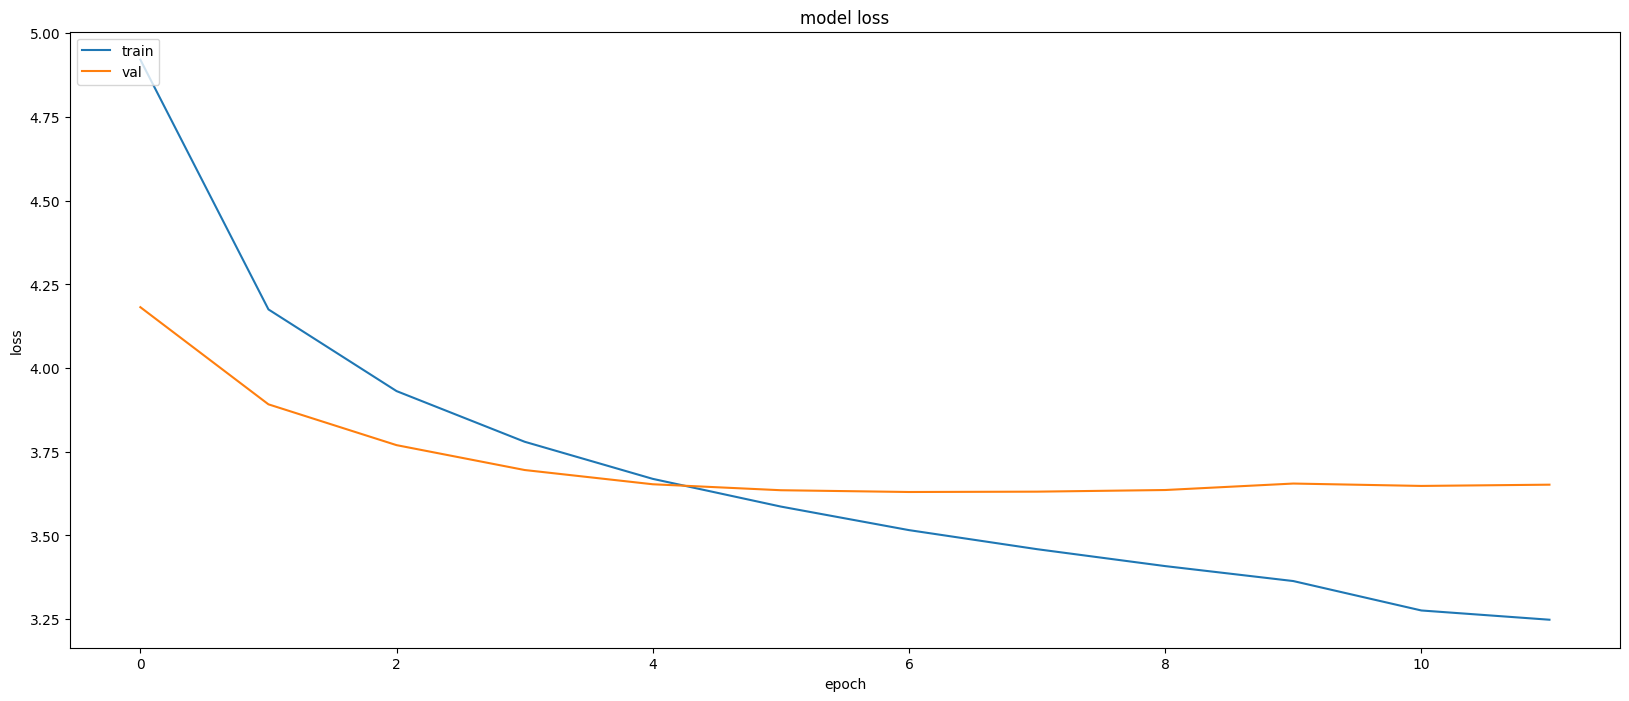

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [36]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Save the artifacts
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

caption_model.save('model.keras')
fe.save('features.keras')

def generate_and_display_caption(image_path, model_path, tokenizer_path, fe_path, max_length=35):
    caption_model = load_model(model_path)
    feature_extractor = load_model(fe_path)
    
    with open(tokenizer_path, 'rb') as f:
        tokenizer = pickle.load(f)
    
    img_size = 224
    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    
    image_features = feature_extractor.predict(img, verbose=0)
    
    in_text = "startseq"
    
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        
        yhat = caption_model.predict([image_features, sequence], verbose=0)
        yhat = np.argmax(yhat)
        
        word = None
        for w, index in tokenizer.word_index.items():
            if index == yhat:
                word = w
                break
        
        if word is None:
            break
            
        in_text += " " + word
        
        if word == 'endseq':
            break
            
    final_caption = in_text.replace('startseq', '').replace('endseq', '')
    
    plt.imshow(plt.imread(image_path))
    plt.title(final_caption)
    plt.axis('off')
    plt.show()
    
    return final_caption

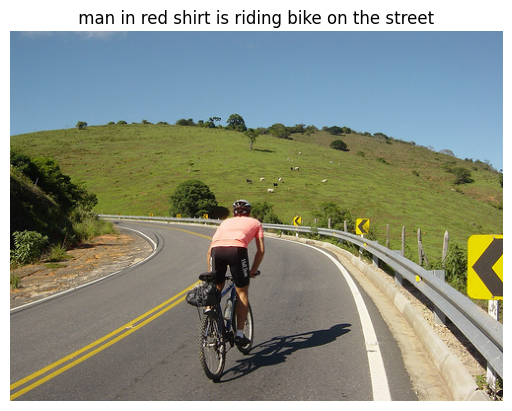

' man in red shirt is riding bike on the street '

In [37]:
model_path = 'model.keras'
feature_extractor_path = 'features.keras'
tokenizer_path = 'tokenizer.pkl'

image_path = "/kaggle/input/flickr8k/Images/110595925_f3395c8bd6.jpg"

generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

In [38]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import DenseNet201 # <--- Import standard model directly

# 1. Load the Tokenizer and Your Trained Model
# (These are the ONLY 2 files you need to download from Kaggle)
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

caption_model = load_model('model.keras')

# 2. Create the Feature Extractor fresh (No need to download it!)
densenet = DenseNet201(weights='imagenet', include_top=False, pooling='avg')

def predict_caption(image_path):
    # --- Step A: Process Image ---
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    
    # --- Step B: Extract Features (Using the fresh DenseNet) ---
    feature = densenet.predict(img, verbose=0)
    
    # --- Step C: Generate Caption ---
    in_text = "startseq"
    max_length = 35 # Make sure this matches your training
    
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        
        yhat = caption_model.predict([feature, sequence], verbose=0)
        yhat = np.argmax(yhat)
        
        word = None
        for w, index in tokenizer.word_index.items():
            if index == yhat:
                word = w
                break
        
        if word is None: break
        
        in_text += " " + word
        if word == 'endseq': break
            
    final_caption = in_text.replace('startseq', '').replace('endseq', '')
    
    # --- Step D: Show Result ---
    plt.imshow(plt.imread(image_path))
    plt.title(final_caption)
    plt.axis('off')
    plt.show()
    return final_caption

# Test it
# predict_caption("test_image.jpg")

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
